## Pre Processing;
1. Pre process file to trim start and end '"'
2. Impute missing column Description and Customer_ID
3. AmountSpent = Unit Price*Total Units

## Segmentation modeling
1. Customer segmentation with total units price and number of units purchased with K-means
2. Using RMF Analysis
3. doc2vec with product description & doc2vec with product description & country
4. Use Fast text or Bert for embed product description

In [3]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import util.pre_process as prep
import util.doc2vec_training as trn

import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
tf.logging.set_verbosity(tf.logging.ERROR)

%matplotlib inline

In [4]:
glob.glob('data/ML*.txt')

['data\\ML Data.txt', 'data\\ML Data_new.txt']

In [5]:
source_file = 'data\\ML Data.txt'
dest_file =  'data\\ML Data_new.txt'
with open (source_file, "r") as infile:
    all_lines = infile.readlines()
with open (dest_file, "w+") as outfile:
    _RE_COMBINE_ = re.compile(r'"+')
    lines = [_RE_COMBINE_.sub('"', line.strip()[1:-1]) for line in all_lines]
    outfile.writelines("%s\n" % l for l in lines)

In [6]:
df = pd.read_csv(dest_file, encoding='latin1', dtype = {'Invoice_Number':'string', 'Product_Code': 'string', 'Description': 'string', 'Quantity': 'int',
       'Invoice_Date':'string', 'Unit_Price':'float', 'Customer_ID':'string', 'Country':'string'})
df.Invoice_Date = pd.to_datetime(df.Invoice_Date)
print(df.shape)
print(df.columns)
display(df.head())

(541909, 8)
Index(['Invoice_Number', 'Product_Code', 'Description', 'Quantity',
       'Invoice_Date', 'Unit_Price', 'Customer_ID', 'Country'],
      dtype='object')


,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [7]:
df.dtypes

Invoice_Number            string
Product_Code              string
Description               string
Quantity                   int32
Invoice_Date      datetime64[ns]
Unit_Price               float64
Customer_ID               string
Country                   string
dtype: object

In [8]:
df.describe(exclude=[np.number])

,Invoice_Number,Product_Code,Description,Invoice_Date,Customer_ID,Country
count,541909,541909,540455,541909,406829,541909
unique,25900,4070,4223,23260,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,17841,United Kingdom
freq,1114,2313,2369,1114,7983,495478
first,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN
last,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN


### Check for duplicate & remove

In [9]:
df.drop_duplicates(inplace=True)
print(df.shape)

(536641, 8)


### Check for occurance of None

In [10]:
df.isna().sum()

Invoice_Number         0
Product_Code           0
Description         1454
Quantity               0
Invoice_Date           0
Unit_Price             0
Customer_ID       135037
Country                0
dtype: int64

### Univariate analysis of product quantity
1. Number of transaction vs cancellation
2. Number of transaction vs cancellation per country
3. Remove cancellation transaction

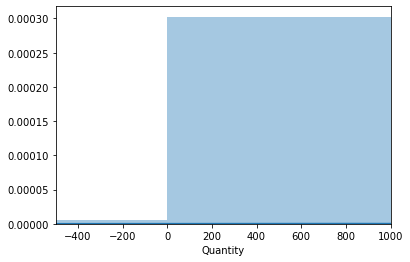

In [11]:
sns.distplot(df.Quantity)
plt.xlim(-500, 1000)
plt.show()

In [12]:
df['Cancellation'] = df.Quantity<0
df.loc[df.Cancellation==True].head()

,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True


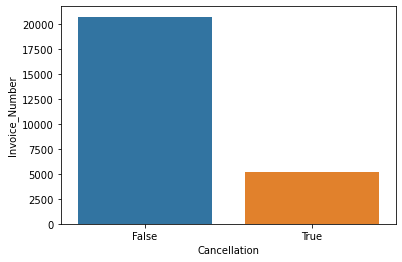

In [13]:
temp_df = df.groupby([df.Cancellation])['Invoice_Number'].nunique().reset_index()
sns.barplot(x='Cancellation',y='Invoice_Number', data=temp_df)

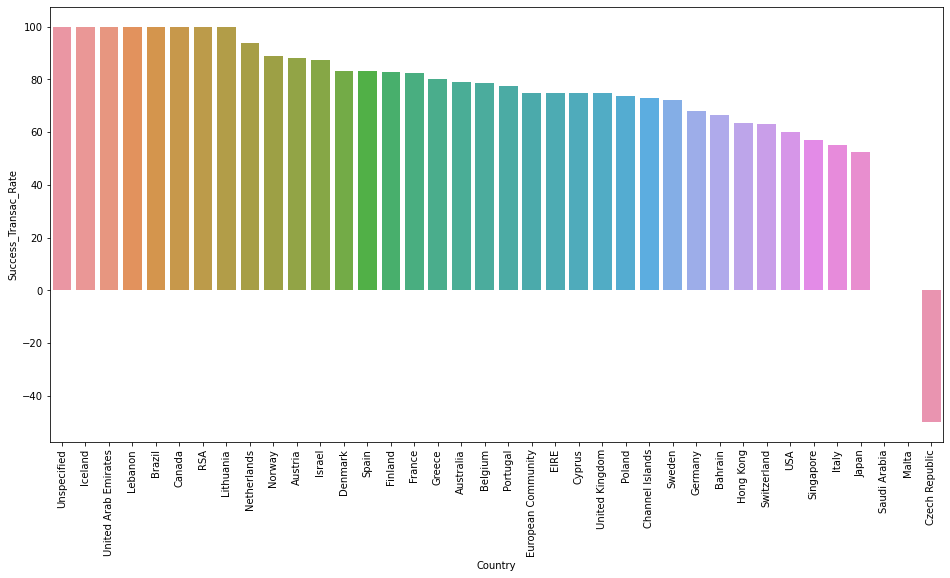

In [14]:
temp_df = df.groupby([df.Cancellation, df.Country])['Invoice_Number'].nunique().reset_index()

temp_df = temp_df.pivot(index='Country', columns='Cancellation', values='Invoice_Number')
temp_df.columns = temp_df.columns.map(lambda x: f'Cancellation_{x}')
temp_df = temp_df.reset_index()
temp_df = temp_df.fillna(0)
temp_df['Success_Transac_Rate'] = ((temp_df.Cancellation_False-temp_df.Cancellation_True)/temp_df.Cancellation_False)*100
plt.figure(figsize=(16, 8))
sns.barplot(x='Country',y='Success_Transac_Rate', data=temp_df, order=temp_df.sort_values('Success_Transac_Rate', ascending=False).Country)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [15]:
print(df.loc[df.Cancellation==True].shape)
df.loc[df.Cancellation==True].head()

(10587, 9)


,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True


In [16]:
df = df.loc[df.Cancellation==False]
print(df.shape)

(526054, 9)


In [17]:
print(df.loc[df.Cancellation==True].shape)
df.loc[df.Cancellation==True].head()

(0, 9)


,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation


### Univariate analysis Unit_Price
1. Removing negative Unit_Price records

In [18]:
df = df.loc[df.Unit_Price>0]
print(df.shape)

(524878, 9)


### Imputing missing product description: 
1. With multi product description replace product description with the most the occurrence description
2. Impute missing description for remaining blank product description

In [19]:
df.Description.isna().sum()

0

In [20]:
df.groupby(['Product_Code'])['Description'].nunique().sort_values(ascending=False)

Product_Code
23236     4
23196     4
17107D    3
22776     3
23366     3
         ..
46776B    1
46776A    1
46775D    1
46138B    1
10002     1
Name: Description, Length: 3922, dtype: int64

In [21]:
product_desc_mapping_df = pd.DataFrame(df.groupby(['Product_Code', 'Description'])['Invoice_Number'].nunique().reset_index()).sort_values(['Product_Code', 'Invoice_Number'], ascending=False).groupby('Product_Code').head(1).drop('Invoice_Number', axis=1)
product_desc_mapping_df.head()

,Product_Code,Description
4160,m,Manual
4159,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00
4158,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
4157,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00
4156,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00


In [22]:
df = pd.merge(df.drop('Description', axis=1), product_desc_mapping_df, how='outer')
df.loc[df.Description.isna(), 'Description'] = 'missing_description'

In [23]:
df.Description.isna().sum()

0

In [24]:
df.groupby(['Product_Code'])['Description'].nunique().sort_values(ascending=False)

Product_Code
m         1
22429     1
22427     1
22426     1
22425     1
         ..
44228     1
44092C    1
44092B    1
44091A    1
10002     1
Name: Description, Length: 3922, dtype: int64

## Imputing missing Customer_ID:
1. Checks to find if missing Customer_ID can be found with any matching invoice number.
2. Check if any particular country exhibits missing Customer_ID.
3. Impute missing customer id as unique customer as per their available transaction id

In [25]:
df.loc[df.Invoice_Number.isin(df.loc[df.Customer_ID.isna(), 'Invoice_Number'].unique())].Customer_ID.unique()

<StringArray>
[<NA>]
Length: 1, dtype: string

In [26]:
df.Country.value_counts()/len(df)

United Kingdom          0.914470
Germany                 0.017194
France                  0.015988
EIRE                    0.015011
Spain                   0.004723
Netherlands             0.004494
Belgium                 0.003869
Switzerland             0.003730
Portugal                0.002843
Australia               0.002250
Norway                  0.002040
Italy                   0.001444
Channel Islands         0.001423
Finland                 0.001305
Cyprus                  0.001149
Sweden                  0.000857
Unspecified             0.000842
Austria                 0.000758
Denmark                 0.000724
Poland                  0.000629
Japan                   0.000612
Israel                  0.000556
Hong Kong               0.000533
Singapore               0.000423
Iceland                 0.000347
USA                     0.000341
Canada                  0.000288
Greece                  0.000276
Malta                   0.000213
United Arab Emirates    0.000130
European C

In [27]:
df.loc[df.Customer_ID.isna(), 'Country'].value_counts()/len(df.Customer_ID.isna())

United Kingdom    0.249166
EIRE              0.001244
Hong Kong         0.000533
Unspecified       0.000383
Switzerland       0.000223
France            0.000126
Israel            0.000090
Portugal          0.000074
Bahrain           0.000002
Name: Country, dtype: float64

In [28]:
df.loc[df.Customer_ID.isna() & df.Country.isin(['United Kingdom']), :].iloc[12:16, :]

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
142,538524,85123A,27,2010-12-13 09:35:00,5.91,<NA>,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
146,538566,85123A,7,2010-12-13 11:21:00,5.91,<NA>,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
199,539434,85123A,4,2010-12-17 14:41:00,5.91,<NA>,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
200,539436,85123A,9,2010-12-17 14:49:00,5.91,<NA>,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


In [29]:
df.loc[df.Customer_ID.isna(), 'Customer_ID'] = 'missing_cust_id_'+df.loc[df.Customer_ID.isna(), 'Invoice_Number']
df.iloc[12:16, :]

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
12,536575,85123A,128,2010-12-01 16:01:00,2.55,13777,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
13,536576,85123A,128,2010-12-01 16:11:00,2.55,13777,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
14,536590,85123A,6,2010-12-01 16:52:00,2.95,13065,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
15,536592,85123A,9,2010-12-01 17:06:00,5.91,missing_cust_id_536592,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


#### Doc2vec with product description

In [83]:
temp_df = df.copy()
display(temp_df.head())

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
1,536373,85123A,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
2,536375,85123A,6,2010-12-01 09:32:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
3,536390,85123A,64,2010-12-01 10:19:00,2.55,17511,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
4,536394,85123A,32,2010-12-01 10:39:00,2.55,13408,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


In [84]:
product_code_2_description_map = pd.DataFrame(temp_df.groupby(['Product_Code'])['Description'].unique()).reset_index()
product_code_2_description_map['Description'] = product_code_2_description_map['Description'].apply(lambda x: x[0])
print(product_code_2_description_map.shape)
product_code_2_description_map.head()

(3922, 2)


,Product_Code,Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10120,DOGGY RUBBER
3,10123C,HEARTS WRAPPING TAPE
4,10124A,SPOTS ON RED BOOKCOVER TAPE


In [85]:
temp_df = pd.DataFrame(temp_df.groupby(['Customer_ID', 'Product_Code'])['Product_Code'].count()).rename({'Product_Code':'n_count'}, axis=1).reset_index().sort_values(['Customer_ID', 'n_count'], ascending=False).groupby(['Customer_ID']).head(5)
temp_df = pd.merge(temp_df, product_code_2_description_map, on ='Product_Code')
temp_df = pd.DataFrame(temp_df.groupby('Customer_ID')['Description'].unique()).reset_index()

temp_df['static_user_profile'] = temp_df.Description.apply(lambda x: ' '.join(x))
temp_df['static_user_profile'] = temp_df['static_user_profile'].str.replace(r"[^A-Za-z0-9 ]+", " ")
temp_df['static_user_profile'] = temp_df['static_user_profile'].str.replace(' +',' ',)

temp_df['static_user_profile'] = prep.preprocess_text(temp_df.static_user_profile, lema_with_spacy=False, stop_word_removal=True)
temp_df['static_user_profile'] = temp_df.static_user_profile.map(lambda x: ' '.join(x))
temp_df['static_user_profile_len'] = temp_df['static_user_profile'].str.len()
model_data = temp_df.copy()
model_data.reset_index(drop=True, inplace=True)
model_data.loc[:, 'static_user_profile_list'] = model_data.static_user_profile.map(lambda x: list(set(x.split(' '))))

In [86]:
model_dir = 'model'
model = trn.training(model_data, True, model_dir)    

if model_data.shape[0] != len(model.docvecs.vectors_docs):
    print('error')

train_corpus[0]:TaggedDocument(['jar', 'ceramic', 'medium', 'storage'], ['12346'])
epochs:30, window:4, vector_size:128, ns_exponent:0.254610887, min_count:4
model training
Model Saved at: model/model_dm0_vector_size128_min_count4_epochs30_window4_ns_exponent0.254610887_alpha0.016691564_min_alpha0.000591644_hs1_seed1234.model
n_correct_prediction: [0.     0.993  0.9975 1.     0.     1.     0.     0.     0.     0.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 1.    ]


In [93]:
if not os.path.exists('projections'):
    os.makedirs('projections')
    
with open("projections/metadata.tsv", 'w+') as file_metadata:
    for i in list(model.docvecs.doctags.keys()):
        file_metadata.write(i + '\n')

In [94]:
sess = tf.InteractiveSession()
d2v = model.docvecs.vectors_docs
with tf.device("/cpu:0"):
    embedding = tf.Variable(d2v, trainable=False, name='embedding')
tf.global_variables_initializer().run()
saver = tf.train.Saver()
writer = tf.summary.FileWriter('projections', sess.graph)
config = projector.ProjectorConfig()
embed= config.embeddings.add()
embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(writer, config)

saver.save(sess, 'projections/model.ckpt', global_step=len(d2v))

c:\users\srikant panda\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


'projections/model.ckpt-5766'

In [116]:
for i, v in model_data.loc[model_data.Customer_ID.isin(['18037', '13663', '12438'])].iterrows():
    print(v['Customer_ID'])
    print(v['Description'])

12438
['FAWN BLUE HOT WATER BOTTLE' 'REGENCY CAKESTAND 3 TIER'
 'BLUE HARMONICA IN BOX ' 'ROUND SNACK BOXES SET OF4 WOODLAND '
 'STRAWBERRY CERAMIC TRINKET BOX']
13663
['RECYCLED ACAPULCO MAT GREEN' 'ASSORTED BOTTLE TOP  MAGNETS '
 'FRIDGE MAGNETS US DINER ASSORTED' 'FRIDGE MAGNETS LA VIE EN ROSE'
 'BAKING MOULD ROSE MILK CHOCOLATE']
18037
['36 PENCILS TUBE SKULLS' 'TOOL BOX SOFT TOY '
 'BLUE POLKADOT GARDEN PARASOL' 'STRAWBERRY LUNCH BOX WITH CUTLERY'
 'BOYS VINTAGE TIN SEASIDE BUCKET']


In [108]:
for i, v in model_data.loc[model_data.Customer_ID.isin(['17613', '15660', '17737'])].iterrows():
    print(v['Customer_ID'])
    print(v['Description'])

15660
['DOORMAT RED RETROSPOT' 'LUNCH BAG CARS BLUE' 'LUNCH BAG SUKI DESIGN '
 'ANTIQUE SILVER T-LIGHT GLASS' 'MULTI COLOUR SILVER T-LIGHT HOLDER']
17613
['RED HANGING HEART T-LIGHT HOLDER' 'WHITE HANGING HEART T-LIGHT HOLDER'
 'ORGANISER WOOD ANTIQUE WHITE ' 'FLORAL FOLK STATIONERY SET'
 'LARGE IVORY HEART WALL ORGANISER']
17737
['SET/5 RED RETROSPOT LID GLASS BOWLS' 'HEART OF WICKER LARGE'
 'SPOTTY BUNTING' 'MULTI COLOUR SILVER T-LIGHT HOLDER'
 'CARD HOLDER GINGHAM HEART']


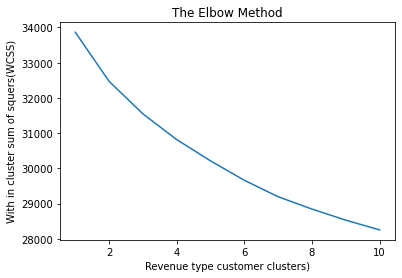

In [89]:
with_in_cluster_sum_squares_list = [] 

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(d2v)
    with_in_cluster_sum_squares_list.append(kmeans.inertia_)

sns.lineplot(x=range(1,11), y= with_in_cluster_sum_squares_list)
plt.title('The Elbow Method')
plt.xlabel('Revenue type customer clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

In [90]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++')
kmeans.fit(d2v)
model_data['Doc2vec_Cluster'] = kmeans.predict(d2v)

print(model_data.Doc2vec_Cluster.nunique())

model_data.head()

6


,Customer_ID,Description,static_user_profile,static_user_profile_len,static_user_profile_list,Doc2vec_Cluster
0,12346,[MEDIUM CERAMIC TOP STORAGE JAR],medium ceramic storage jar,26,"[jar, ceramic, medium, storage]",4
1,12347,"[WOODLAND CHARLOTTE BAG, ALARM CLOCK BAKELIKE ...",woodland charlotte bag alarm clock bakelike re...,139,"[light, playing, clock, charlotte, set, #d, al...",1
2,12348,"[POSTAGE, PACK OF 60 PINK PAISLEY CAKE CASES, ...",postage pack ## pink paisley cake case pack ##...,112,"[pink, pack, cake, paisley, skull, case, dough...",1
3,12349,"[DOORMAT RED RETROSPOT, SET/5 RED RETROSPOT LI...",doormat red retrospot set # red retrospot lid ...,142,"[lid, retrospot, metal, box, trinket, painted,...",5
4,12350,"[BLUE POLKADOT PASSPORT COVER, BLUE POLKADOT L...",blue polkadot passport cover blue polkadot lug...,126,"[passport, luggage, tag, polkadot, union, jack...",5


In [92]:
for i in range(6):
    print('*'*10)
    print(i)
    print('*'*10)
    for i, v in model_data.loc[model_data.Doc2vec_Cluster==i, ['Description', 'static_user_profile']].head(2).iterrows():
        print(v['static_user_profile'])
        print('-'*10)

**********
0
**********
green polkadot bowl party time pencil eraser blue polkadot bowl heart calculator swirly circular rubber bag
----------
brocade ring purse postage ## pencil small tube red retrospot party metal sign ## pencil small tube skull
----------
**********
1
**********
woodland charlotte bag alarm clock bakelike red red toadstool led night light airline bag vintage jet set brown #d dog picture playing card
----------
postage pack ## pink paisley cake case pack ## skull cake case ## cake case vintage christmas doughnut lip gloss
----------
**********
2
**********
red floral feltcraft shoulder bag pink floral feltcraft shoulder bag feltcraft cushion owl white tall porcelain t light holder lantern cream gazebo
----------
red retrospot mini case assorted colour mini case large cake stand hanging strawbery mini cake stand hanging strawbery assorted tutti frutti small purse
----------
**********
3
**********
red retrospot bowl pink polkadot bowl blue polkadot bowl assorted colo